In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - 1D_radial_DF_model.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Look at some of the model calculated triaxial DFs
'''

__author__ = "James Lane"

In [2]:
## Imports

## Basic
import numpy as np
import sys, os, pdb, glob
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.potential
import ast1501.util
import ast1501.fourier

In [3]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta

## Future work

## Information
- Galpy notes on the DF: https://galpy.readthedocs.io/en/latest/diskdf.html
- Galpy notes on the actions: https://galpy.readthedocs.io/en/latest/actionAngle.html

# Prepare
Declare the keywords for the analysis, make the potential, and the DF

## Keywords and File Names

In [18]:
file_base = './data/results_b'
file_specs = ['90.npy','95.npy','98.npy','102.npy','105.npy','110.npy']
files = [ file_base+spec for spec in file_specs]
n_files = len(files)
b_values = [0.9,0.95,0.98,1.02,1.05,1.1]
print(files)

# Plotting
file_colors = ['DodgerBlue','ForestGreen','Navy','Red','Purple','DarkOrange']

['./data/results_b90.npy', './data/results_b95.npy', './data/results_b98.npy', './data/results_b102.npy', './data/results_b105.npy', './data/results_b110.npy']


In [19]:
## Assuming all files have the same radial and phi structure get the number of radial bins
data_tmp = np.load(files[0])
R_range = np.unique(data_tmp[:,0])
R_bin_size = np.diff(R_range)[0]

# Fit Sinusoids to Velocity Fluctuations 

## Tangential Velocity

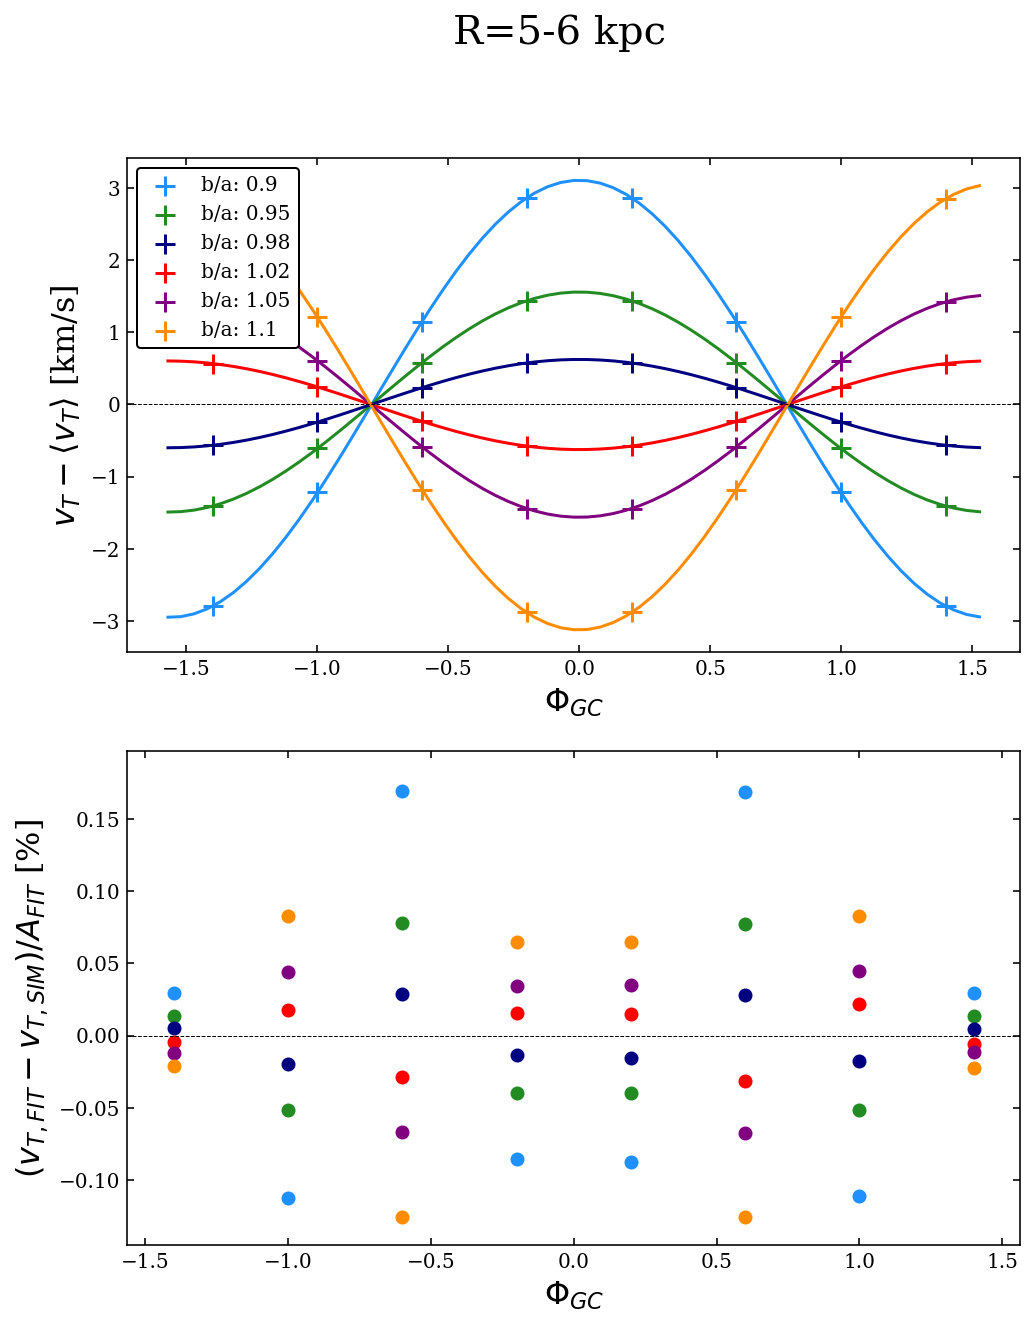

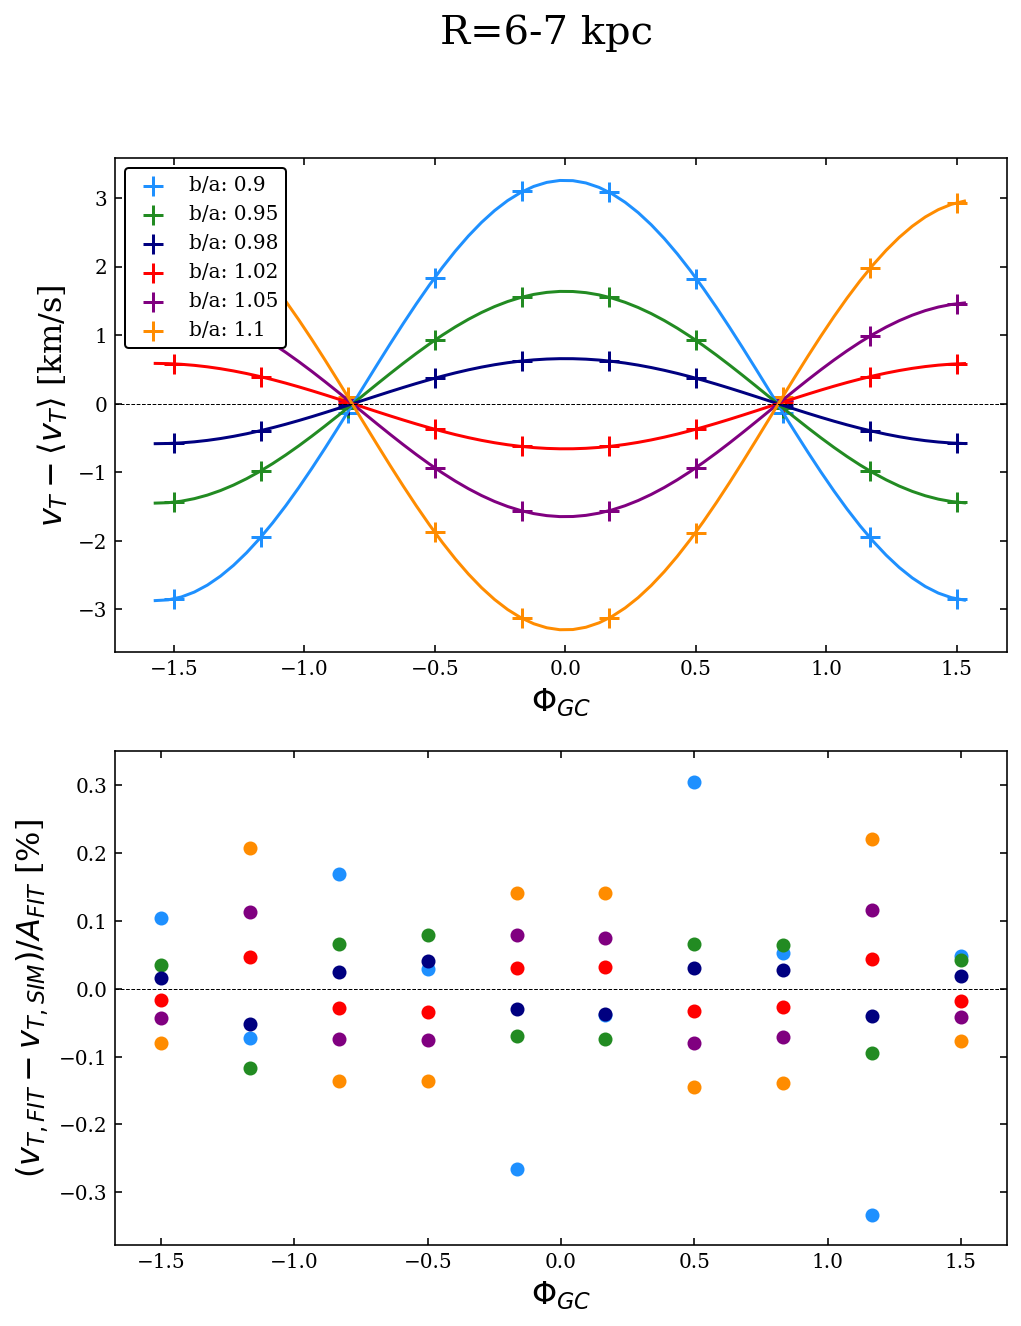

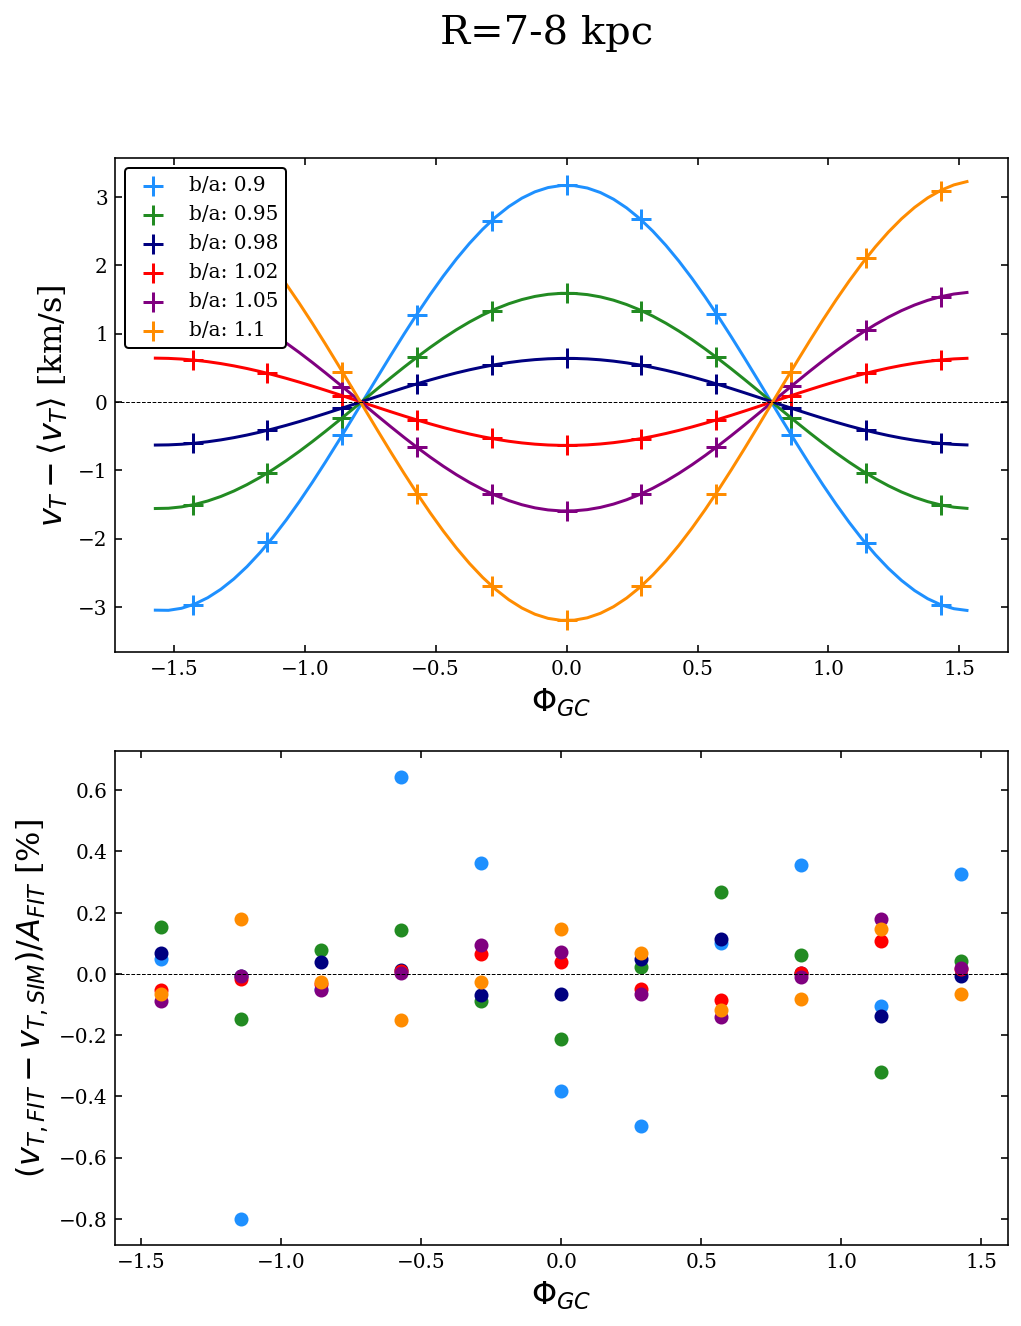

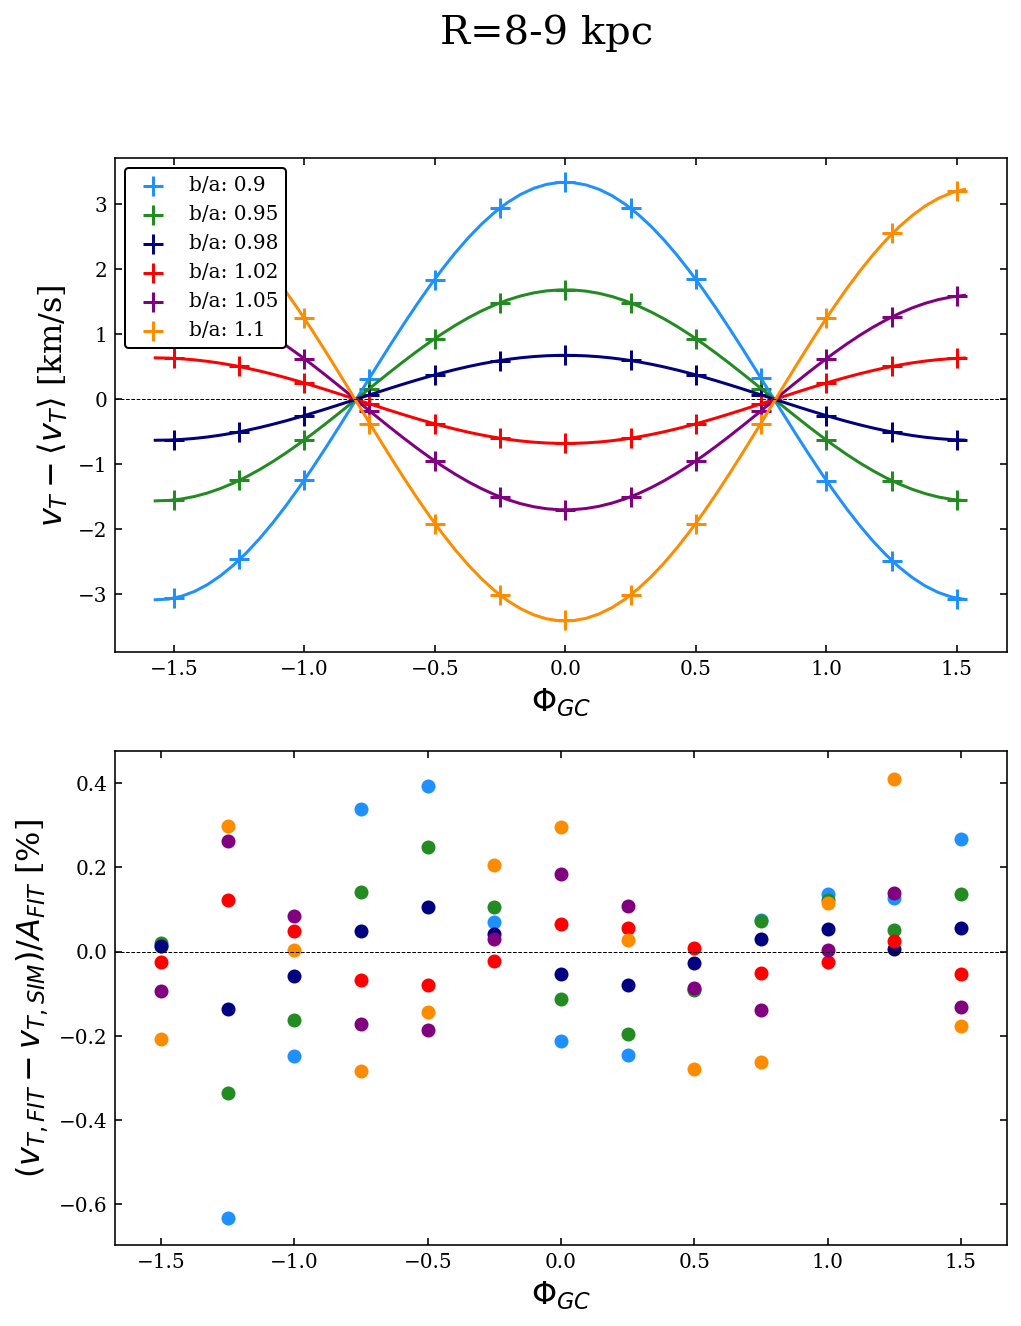

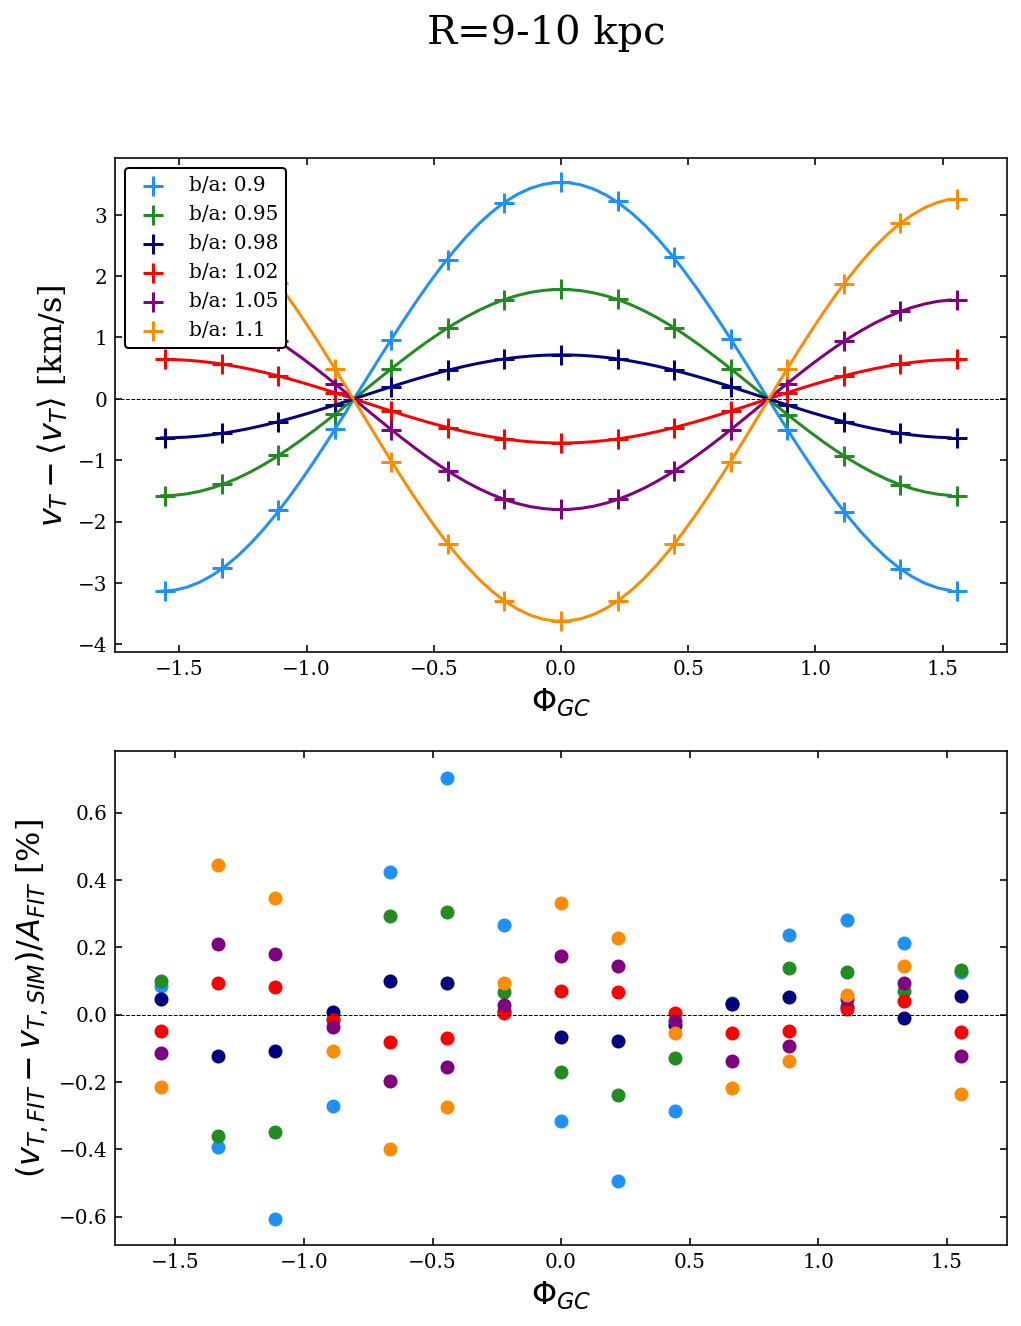

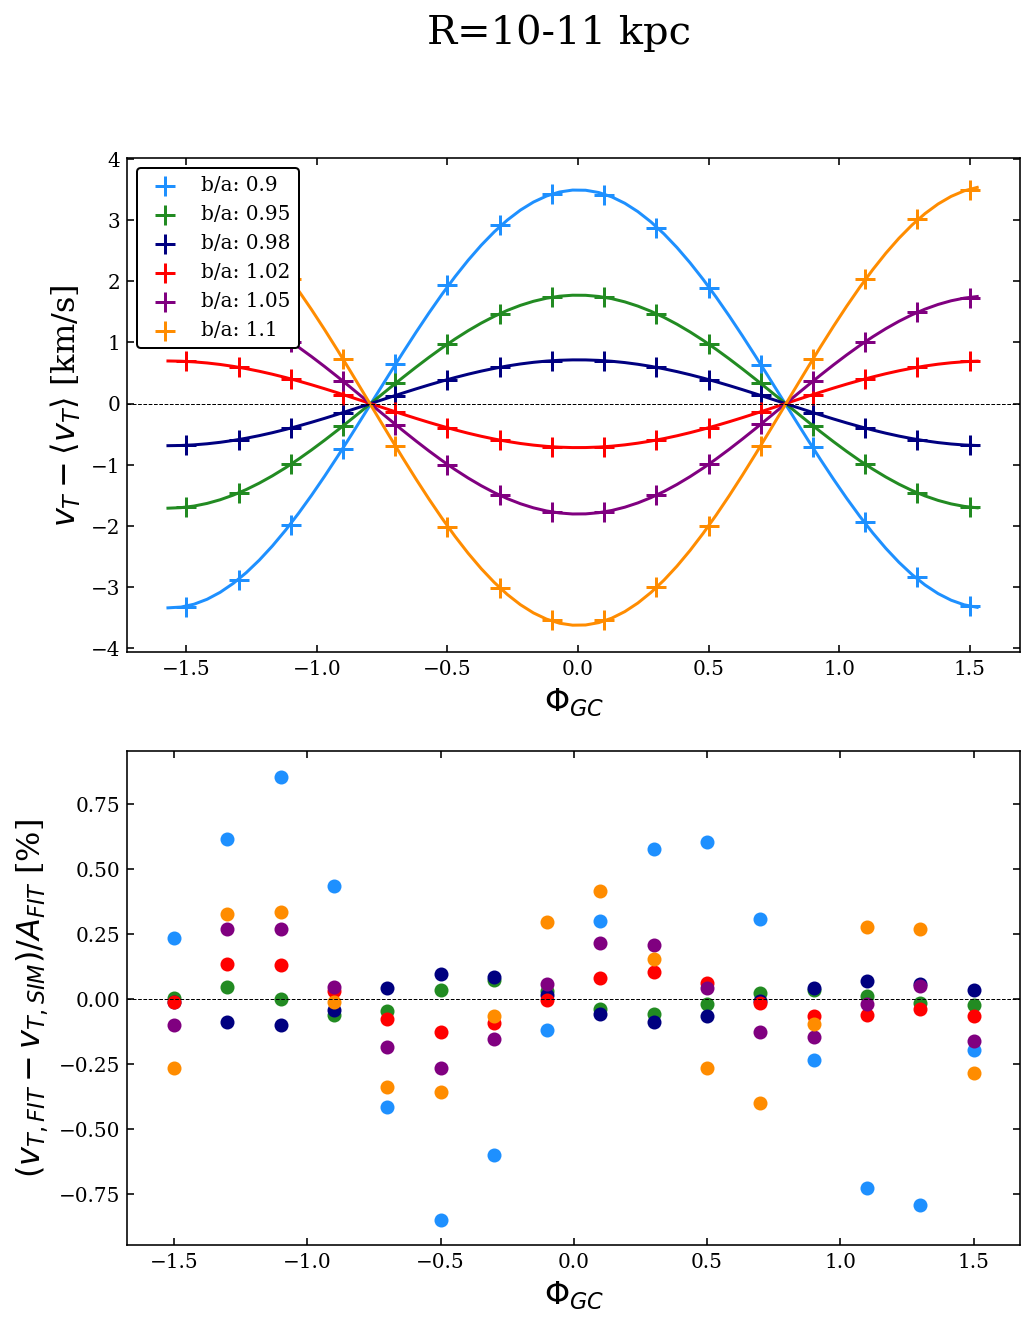

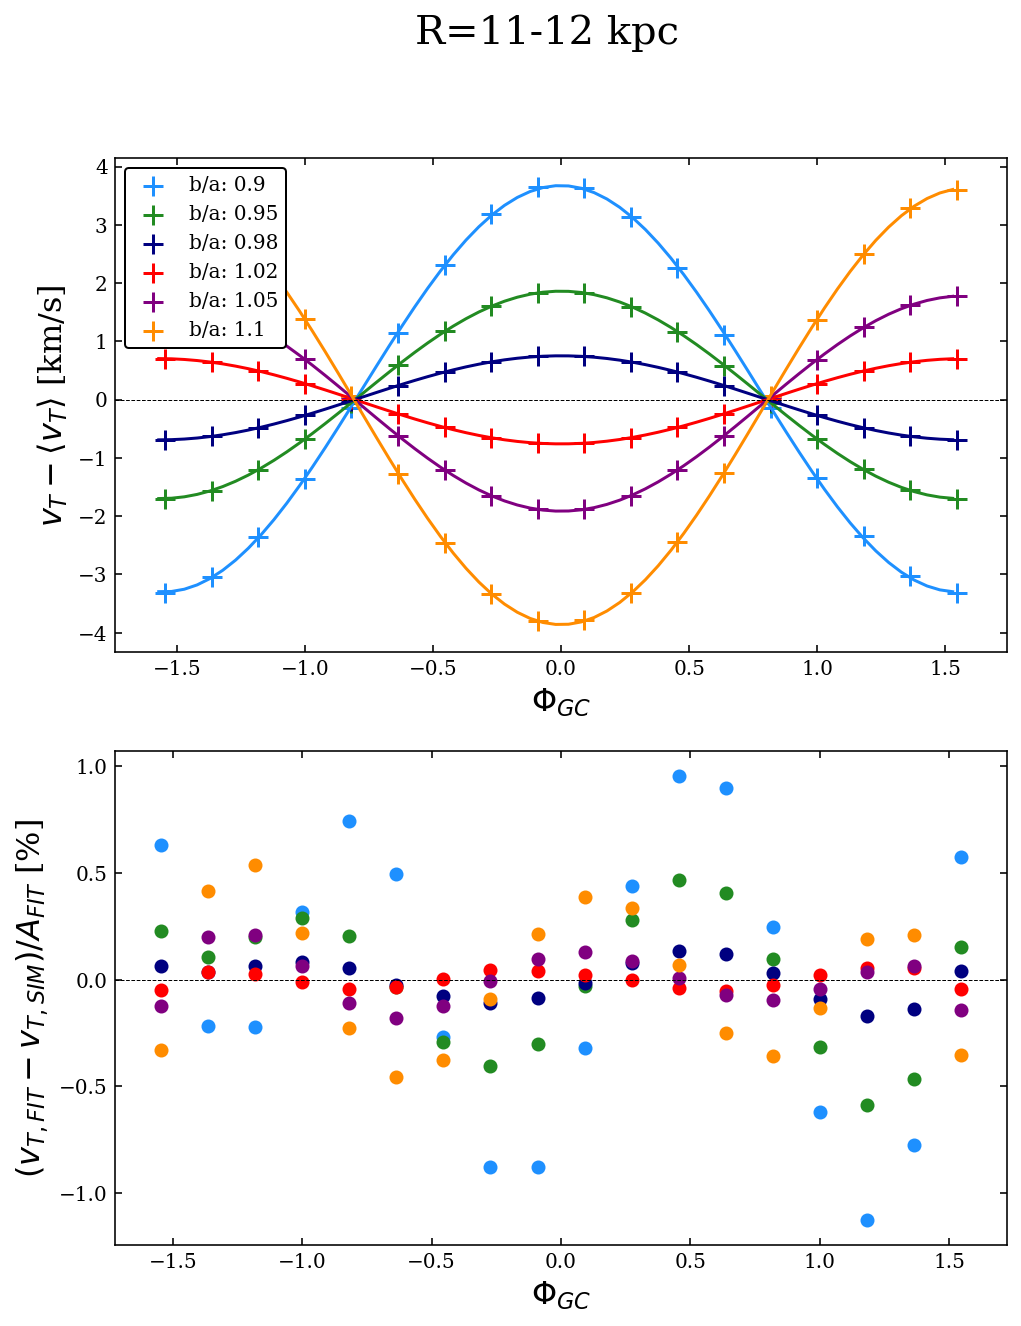

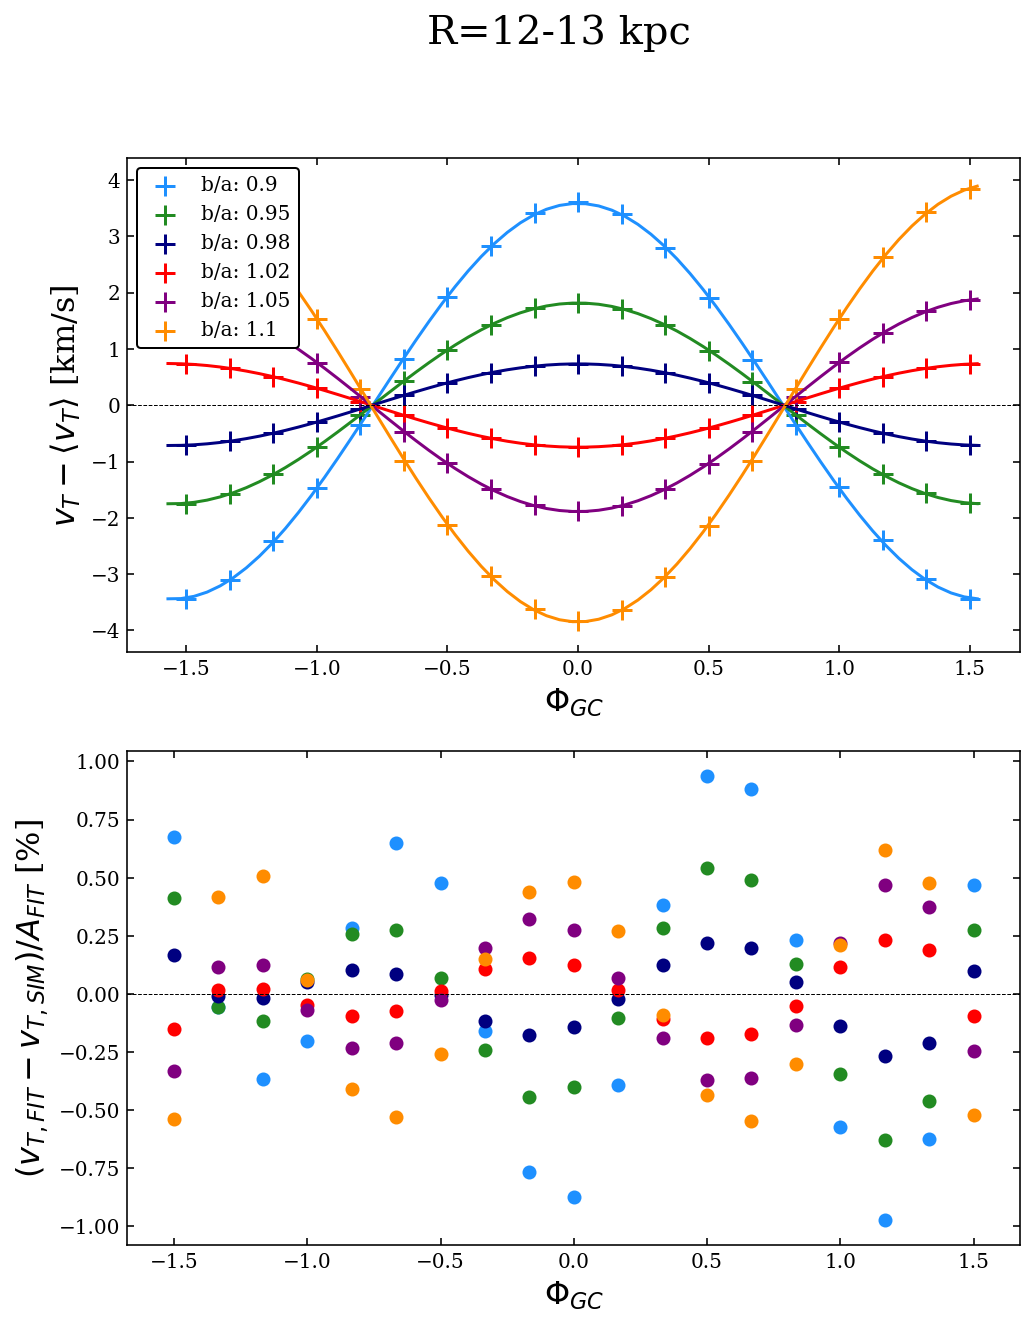

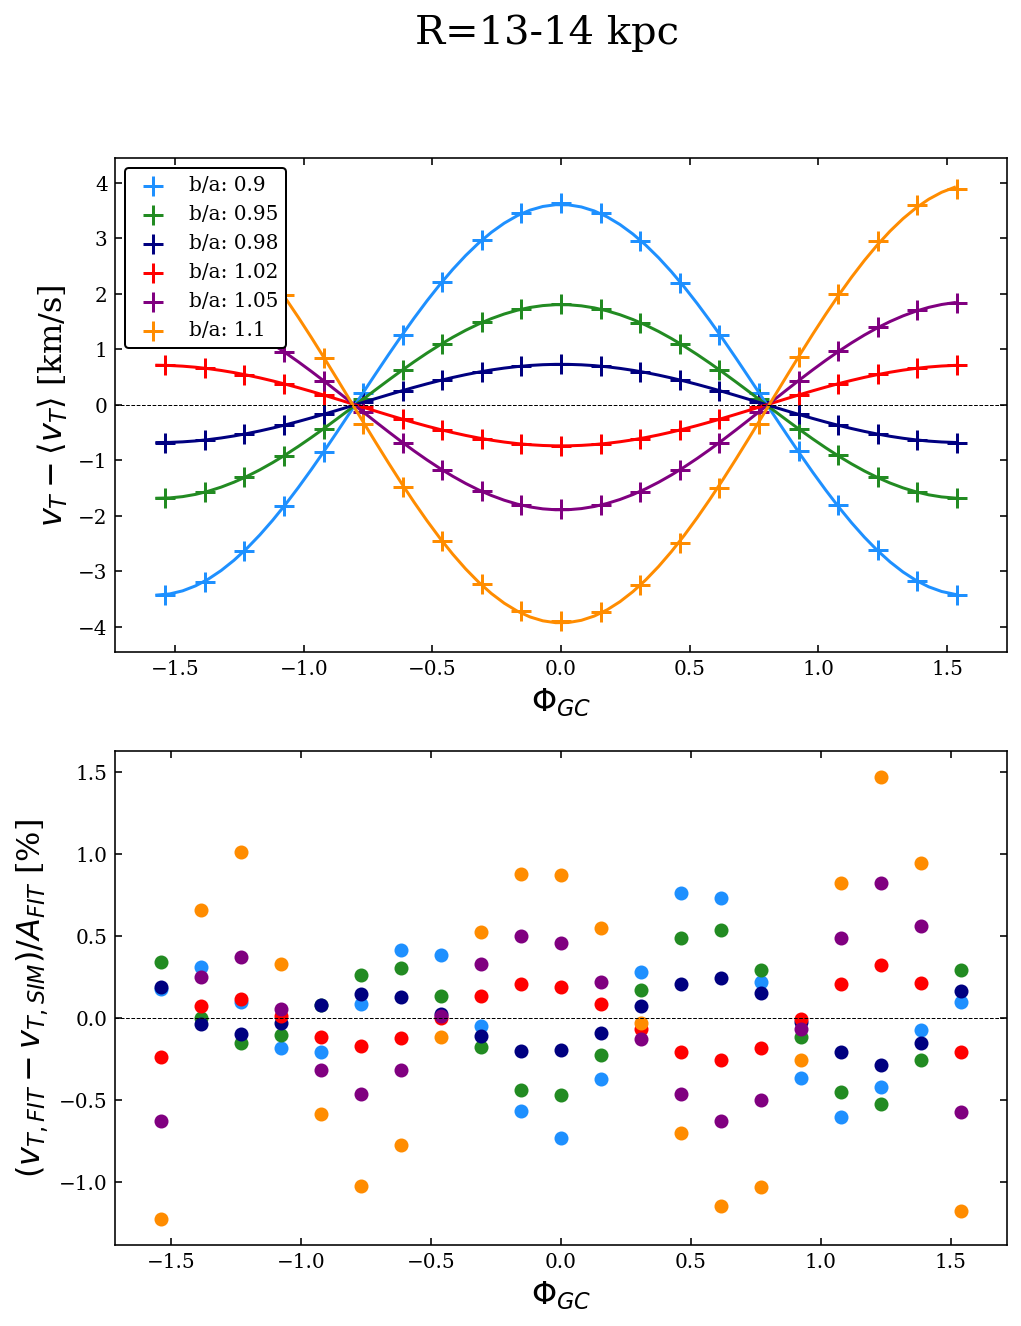

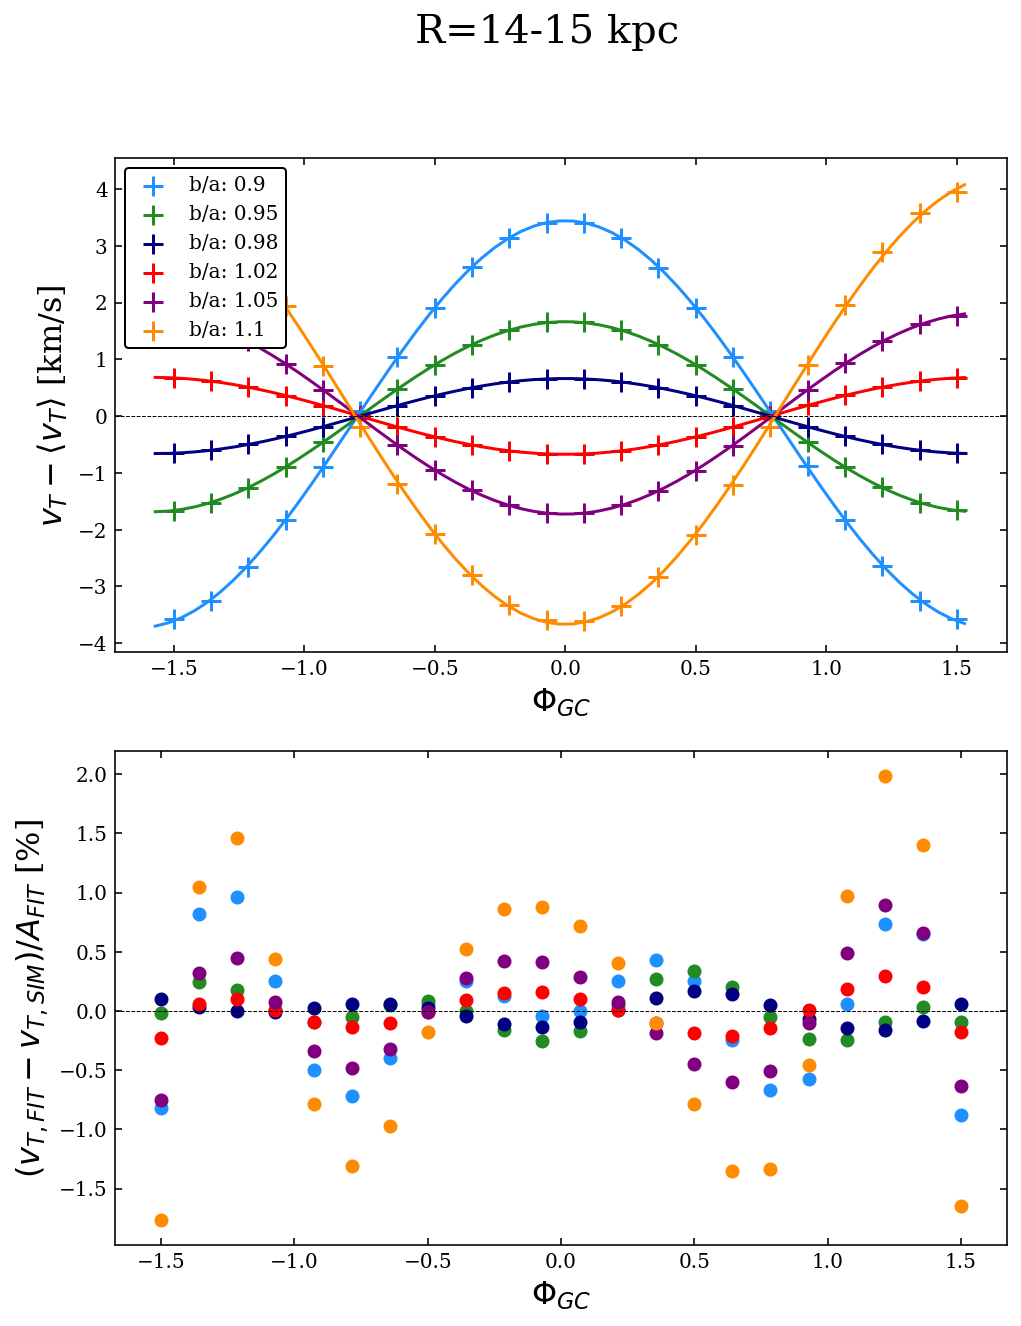

In [23]:
# Define the sinusoid fitting function:
def sinusoid(x,A,om,phase,D):
    return A*np.cos(om*x + phase) + D
#def

# Create arrays to keep track of array amplitudes
vt_fit_amplitudes = np.zeros((len(R_range),n_files))

# Now loop over each radial bin
for i in range( len(R_range) ):
    
    # Plot
    fig = plt.figure( figsize=(8,10) )
    axs = fig.subplots(nrows=2, ncols=1)
    
    # Loop over each file
    for j in range(n_files):
        
        # Load data
        sim_halo_data = np.load(files[j])
        where_current_r = np.where( sim_halo_data[:,0] == R_range[i] )[0]
        sim_halo_vt = sim_halo_data[ where_current_r, 6 ]
        sim_halo_vt -= np.mean(sim_halo_vt)
        sim_halo_phi = sim_halo_data[ where_current_r, 1 ]
        
        # Plot the data
        axs[0].scatter(sim_halo_phi, sim_halo_vt, color=file_colors[j], marker='+', 
                       label='b/a: '+str(b_values[j]), s=100)
        
        # Plot the cosine fit to the data
        popt, pcov = curve_fit(sinusoid, sim_halo_phi, sim_halo_vt, p0=[10,2.,0.0,0], ftol=0.01)
        fit_phi = np.arange(-np.pi/2,np.pi/2,0.05)
        axs[0].plot( fit_phi, sinusoid(fit_phi, *popt), color=file_colors[j], linestyle='solid')
    
        # Plot the residuals between the fit and the data
        axs[1].scatter( sim_halo_phi, 100*(sinusoid(sim_halo_phi, *popt)-sim_halo_vt)/popt[0], color=file_colors[j] )
        
        # Record the amplitude
        vt_fit_amplitudes[i,j] = popt[0]
        
    ###j
    
    axs[0].legend(loc='upper left')
    axs[0].set_xlabel(r'$\Phi_{GC}$', fontsize=16)
    axs[0].set_ylabel(r'$v_{T}- \langle {v_{T}} \rangle$ [km/s]', fontsize=16)
    axs[0].axhline(0, linestyle='dashed', color='Black', linewidth=0.5)
    
    axs[1].legend(loc='upper left')
    axs[1].set_xlabel(r'$\Phi_{GC}$', fontsize=16)
    axs[1].set_ylabel(r'$(v_{T,FIT}-v_{T,SIM})/A_{FIT}$ [%]', fontsize=16)
    axs[1].axhline(0, linestyle='dashed', color='Black', linewidth=0.5)
    
    fig.suptitle('R='+str(int(R_range[i]))+'-'+str(int(R_range[i]+R_bin_size))+' kpc', fontsize=20)
    
    plt.show()
#     plt.close('all')

## Radial Velocity

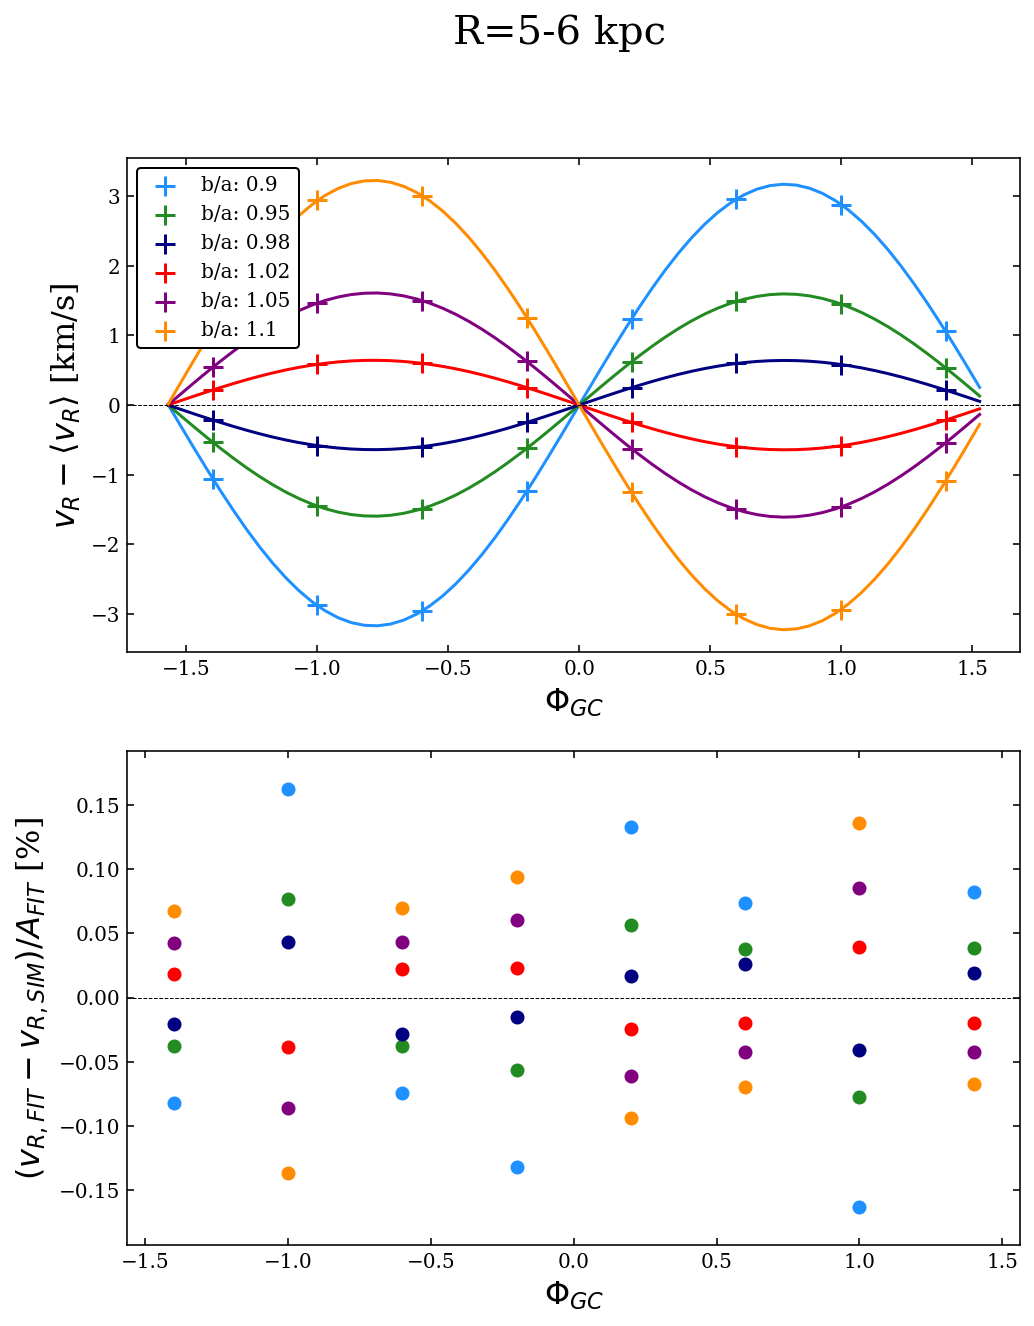

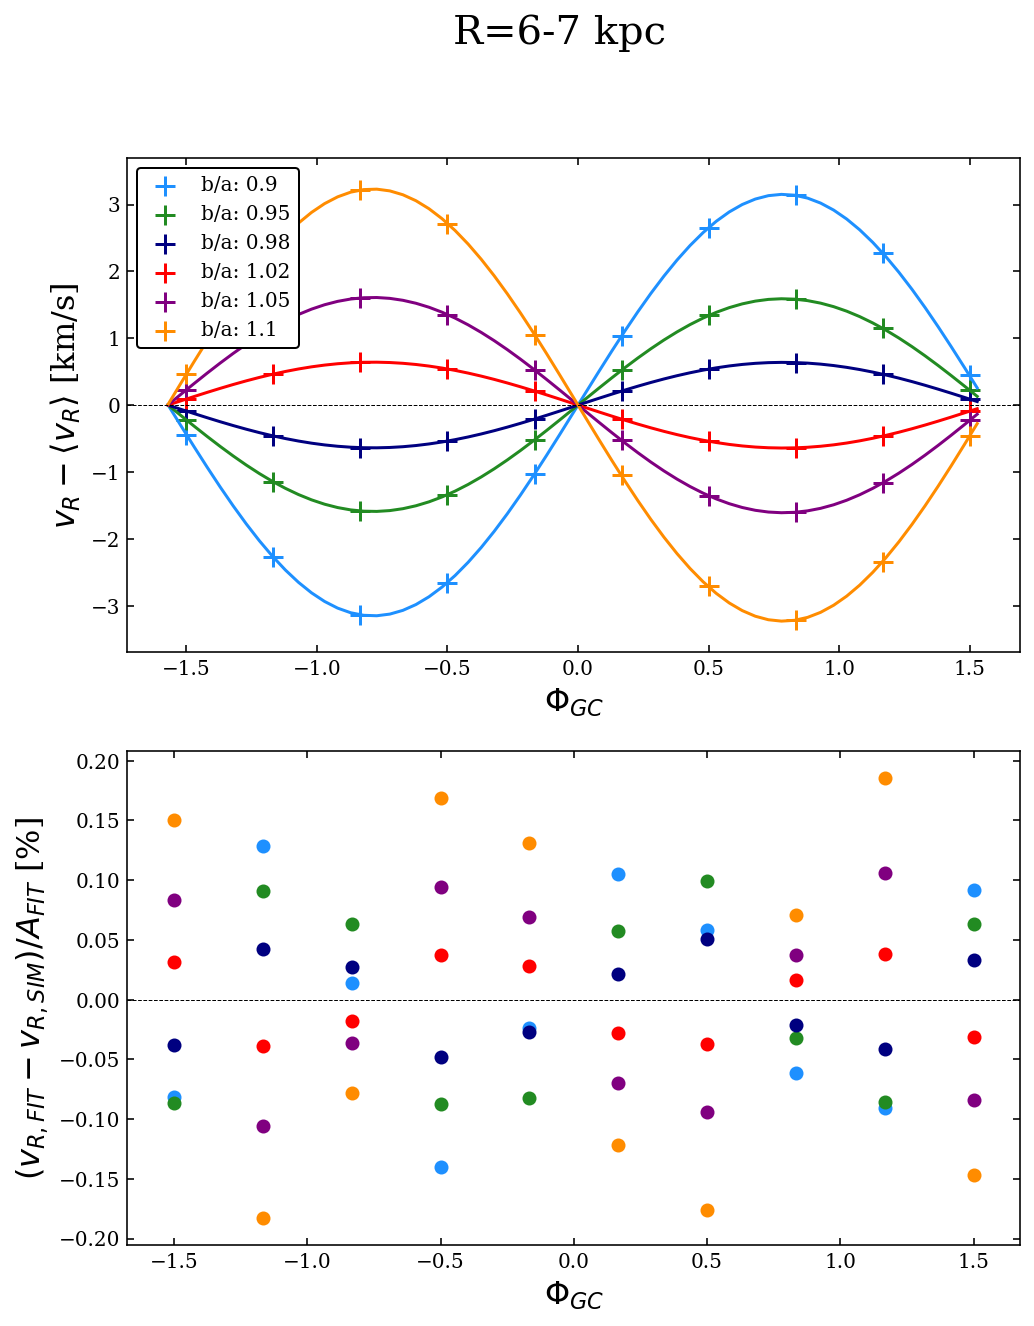

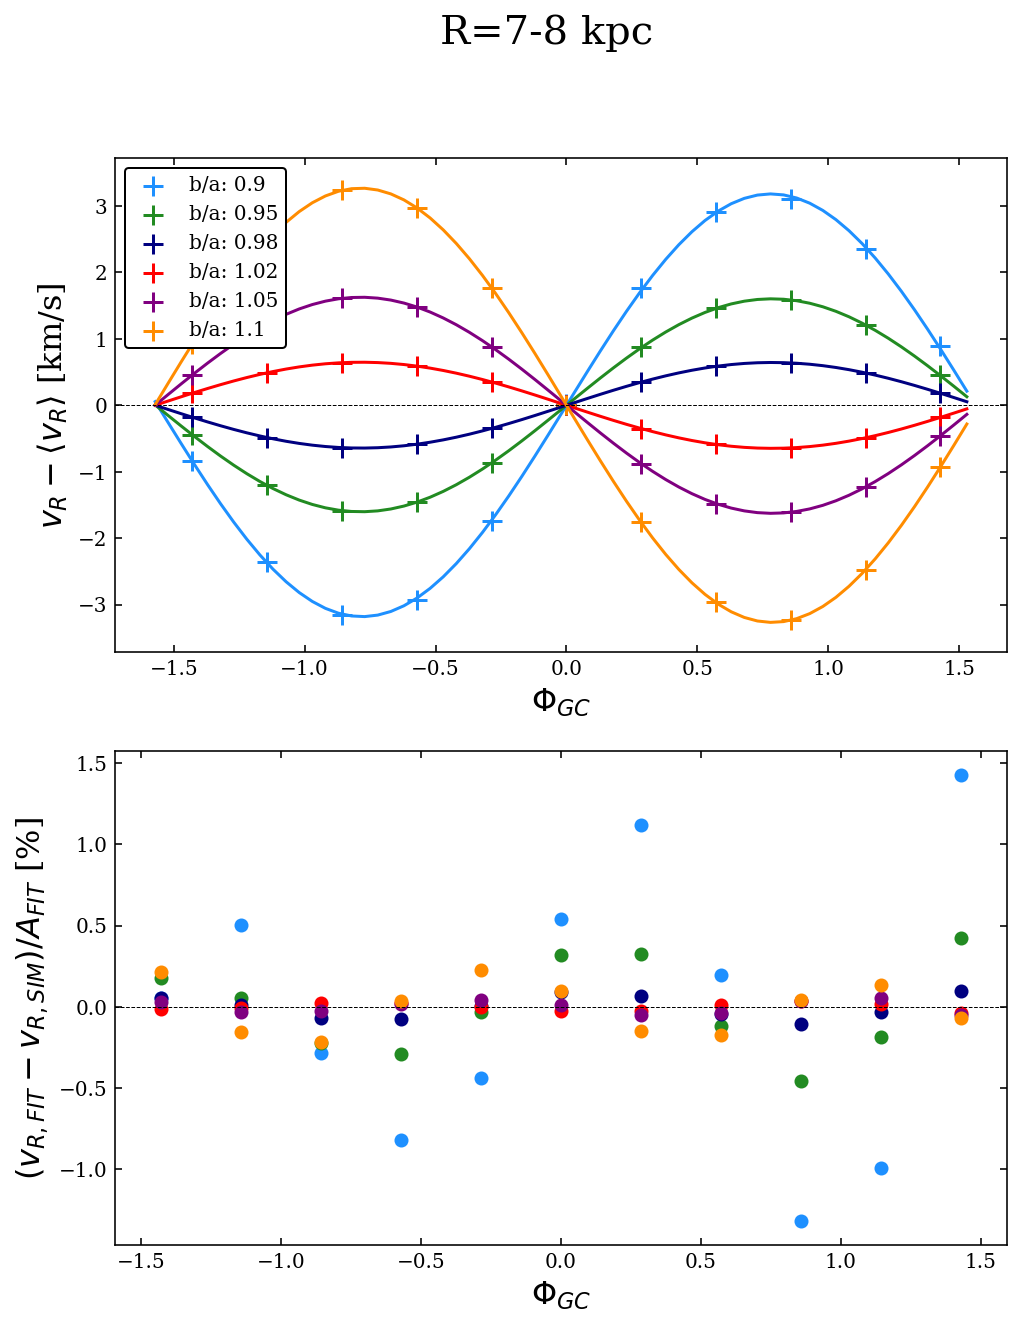

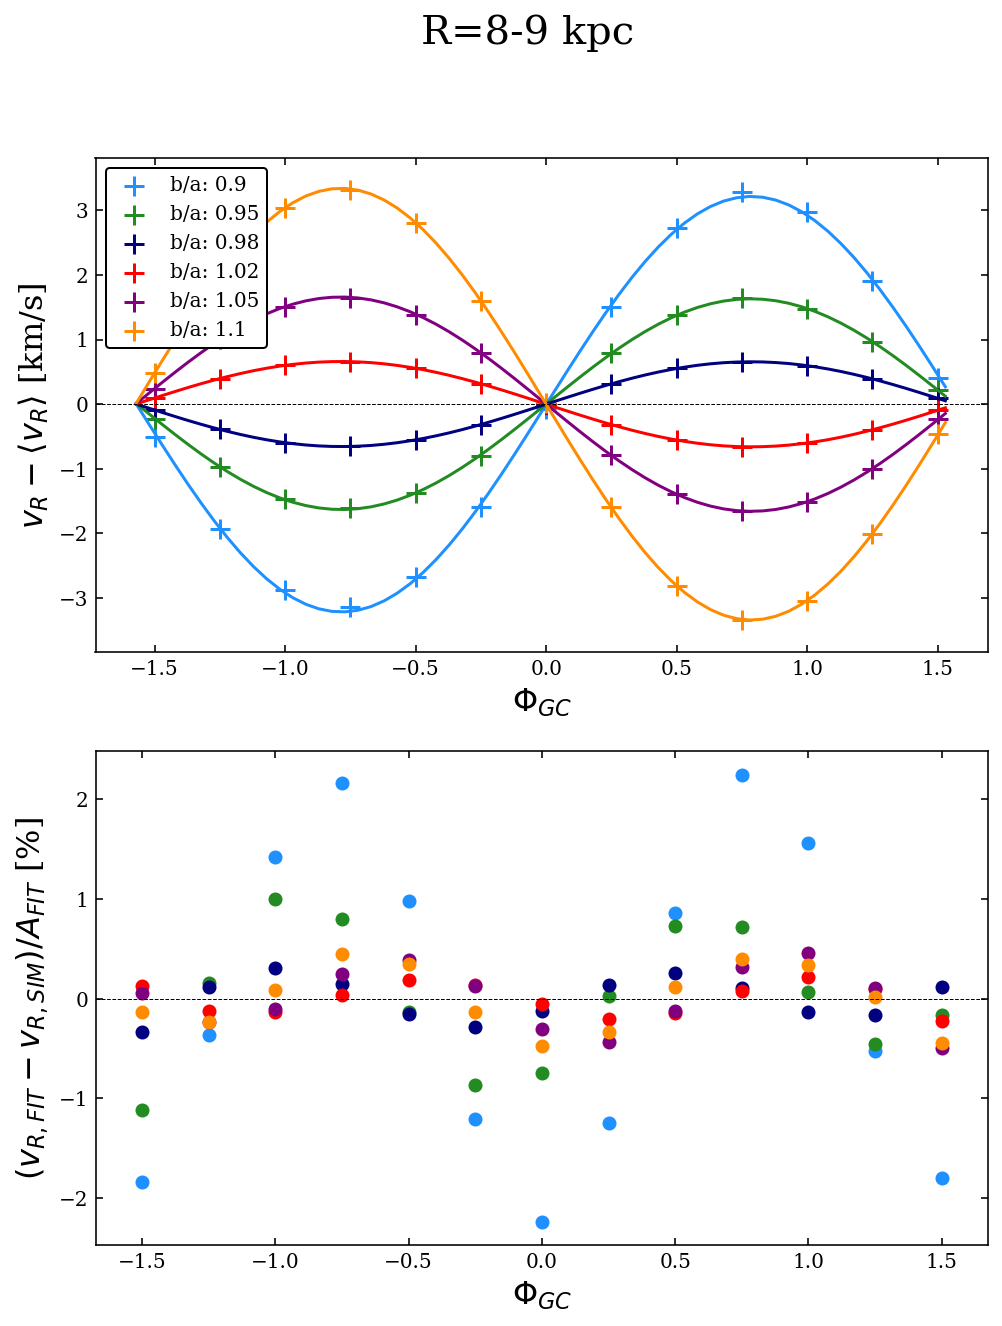

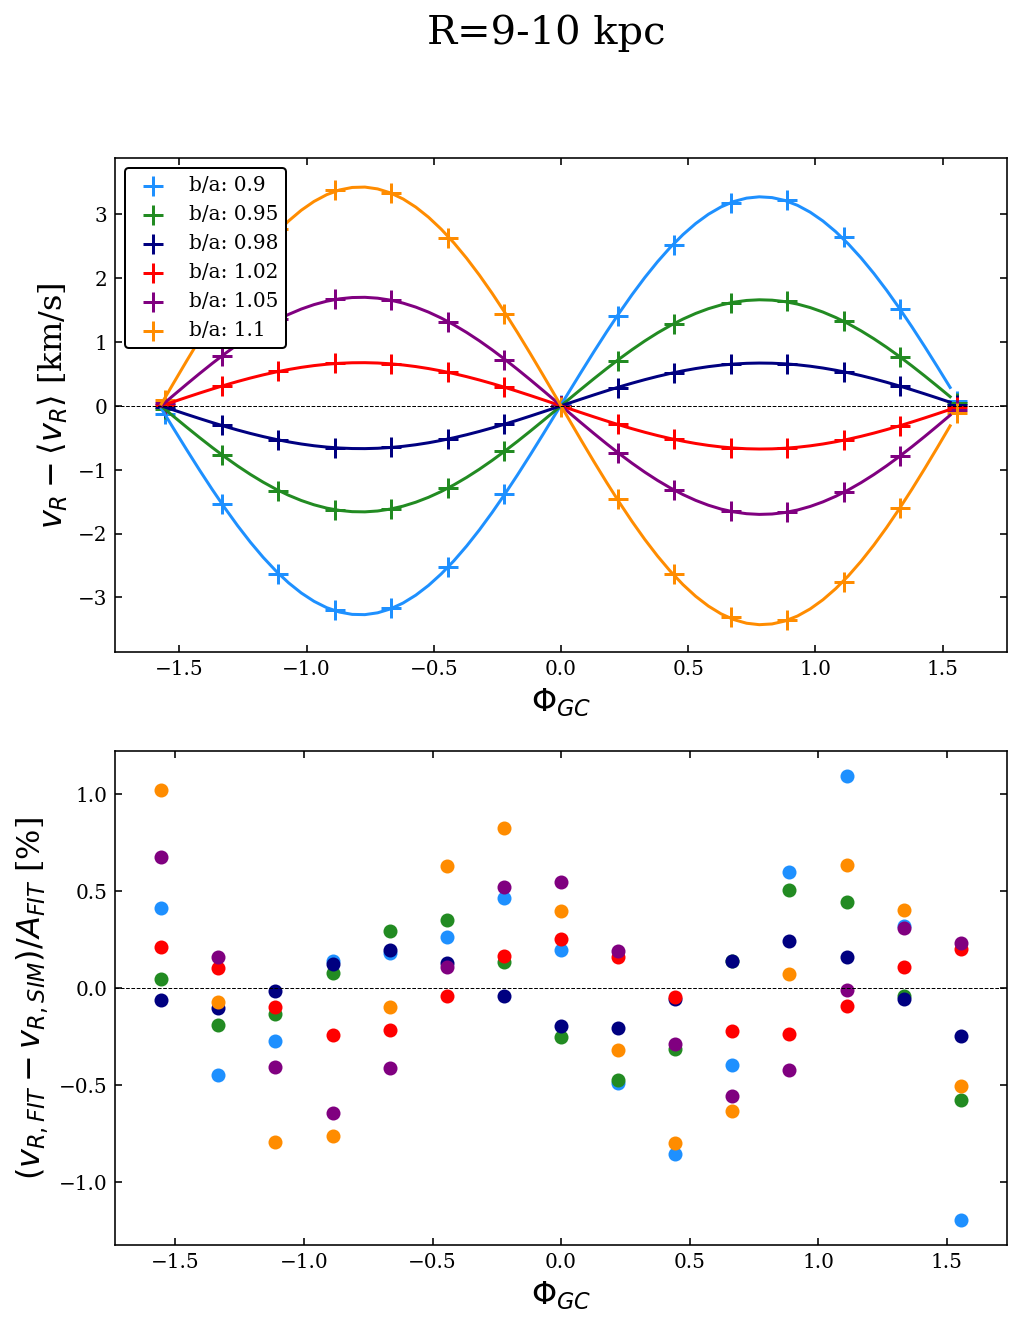

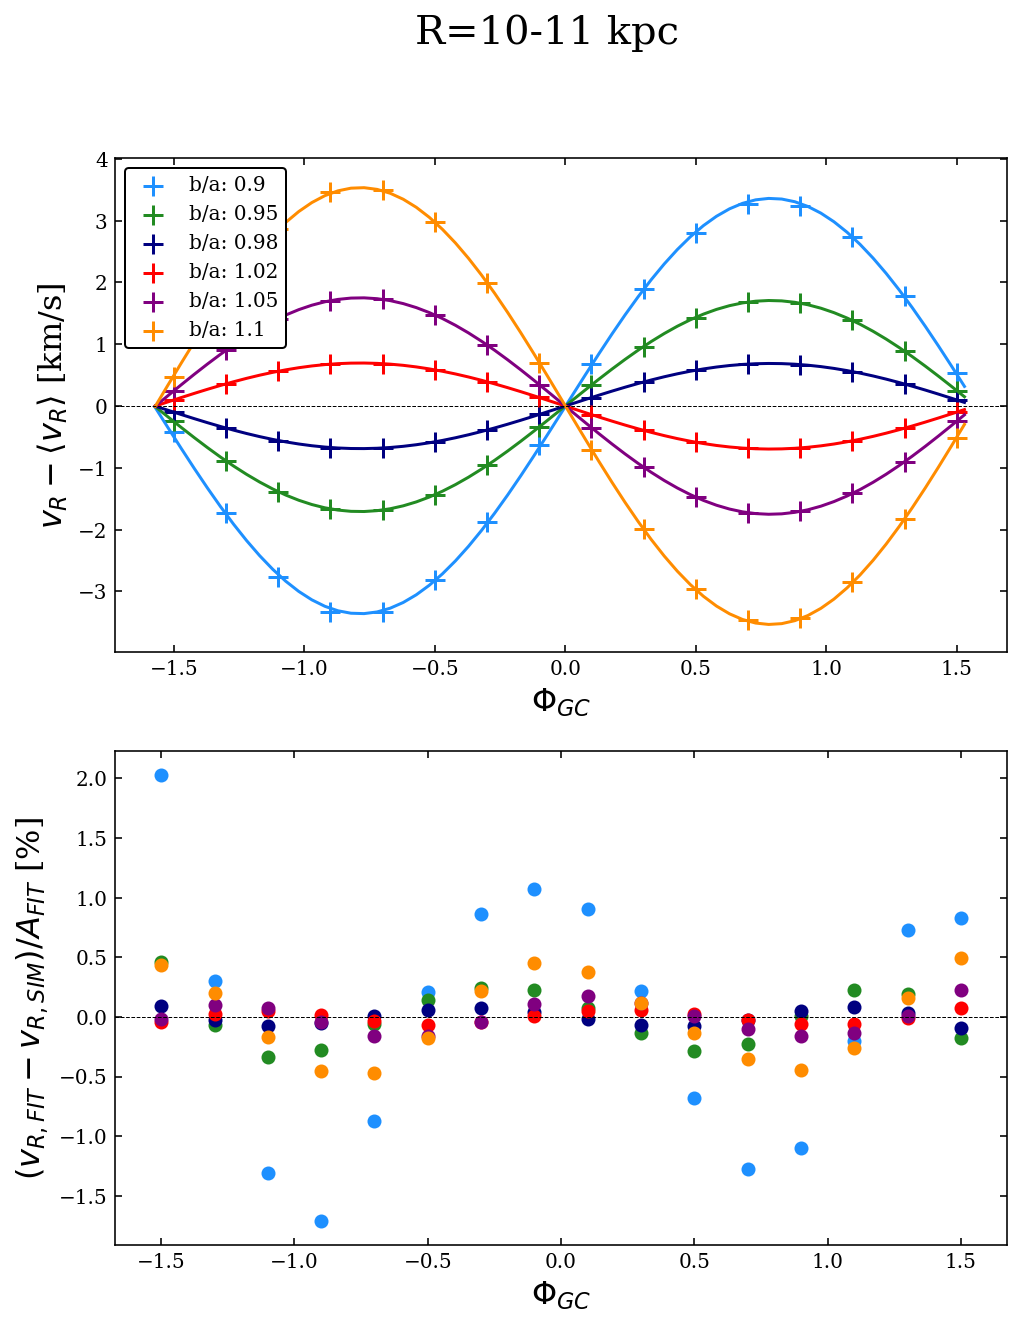

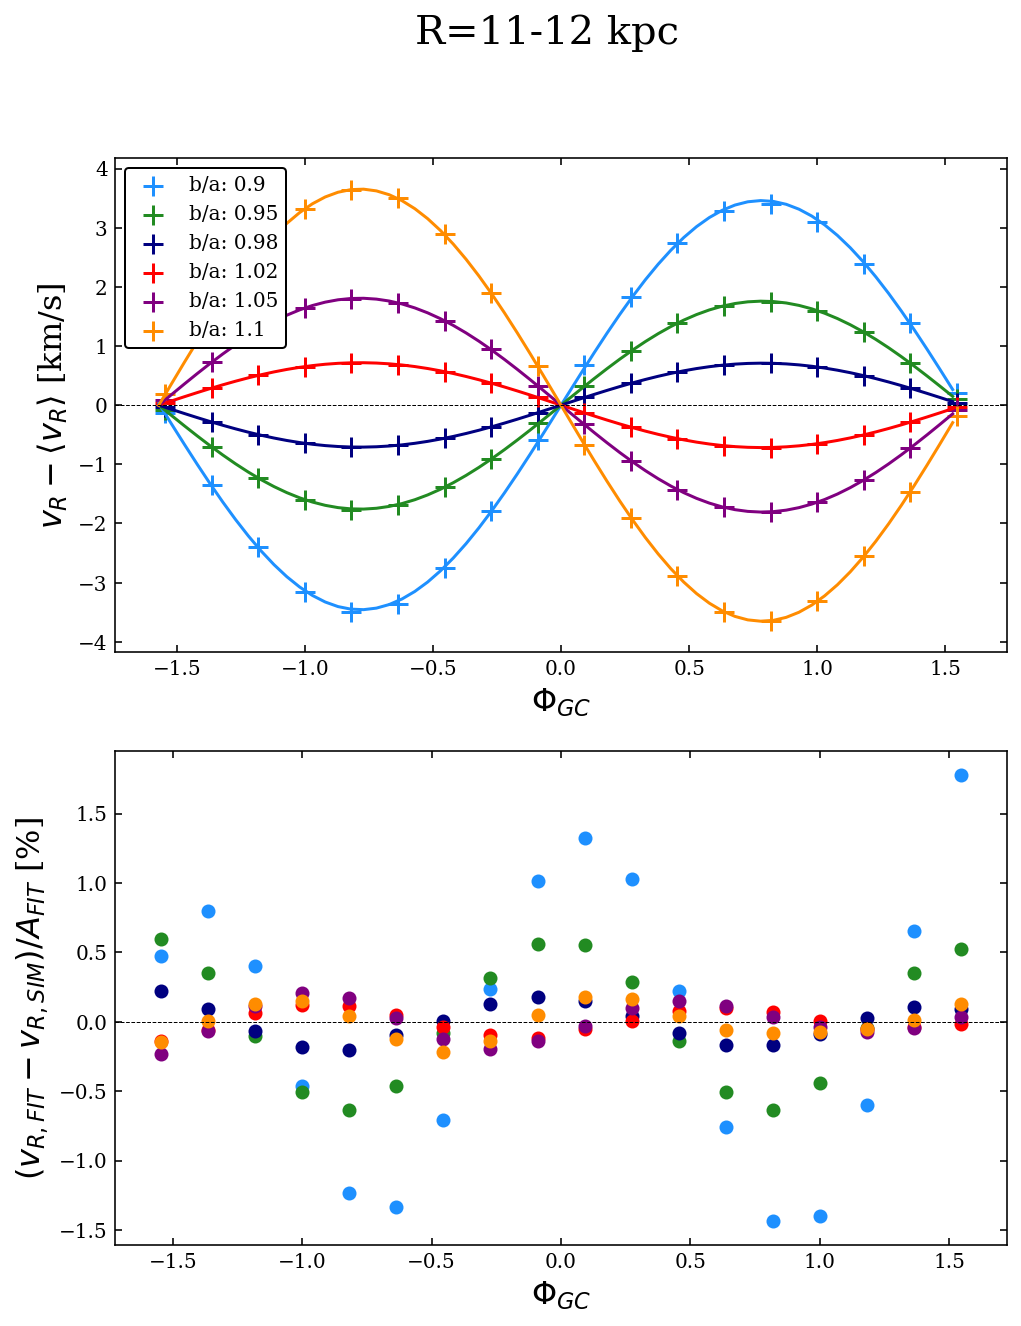

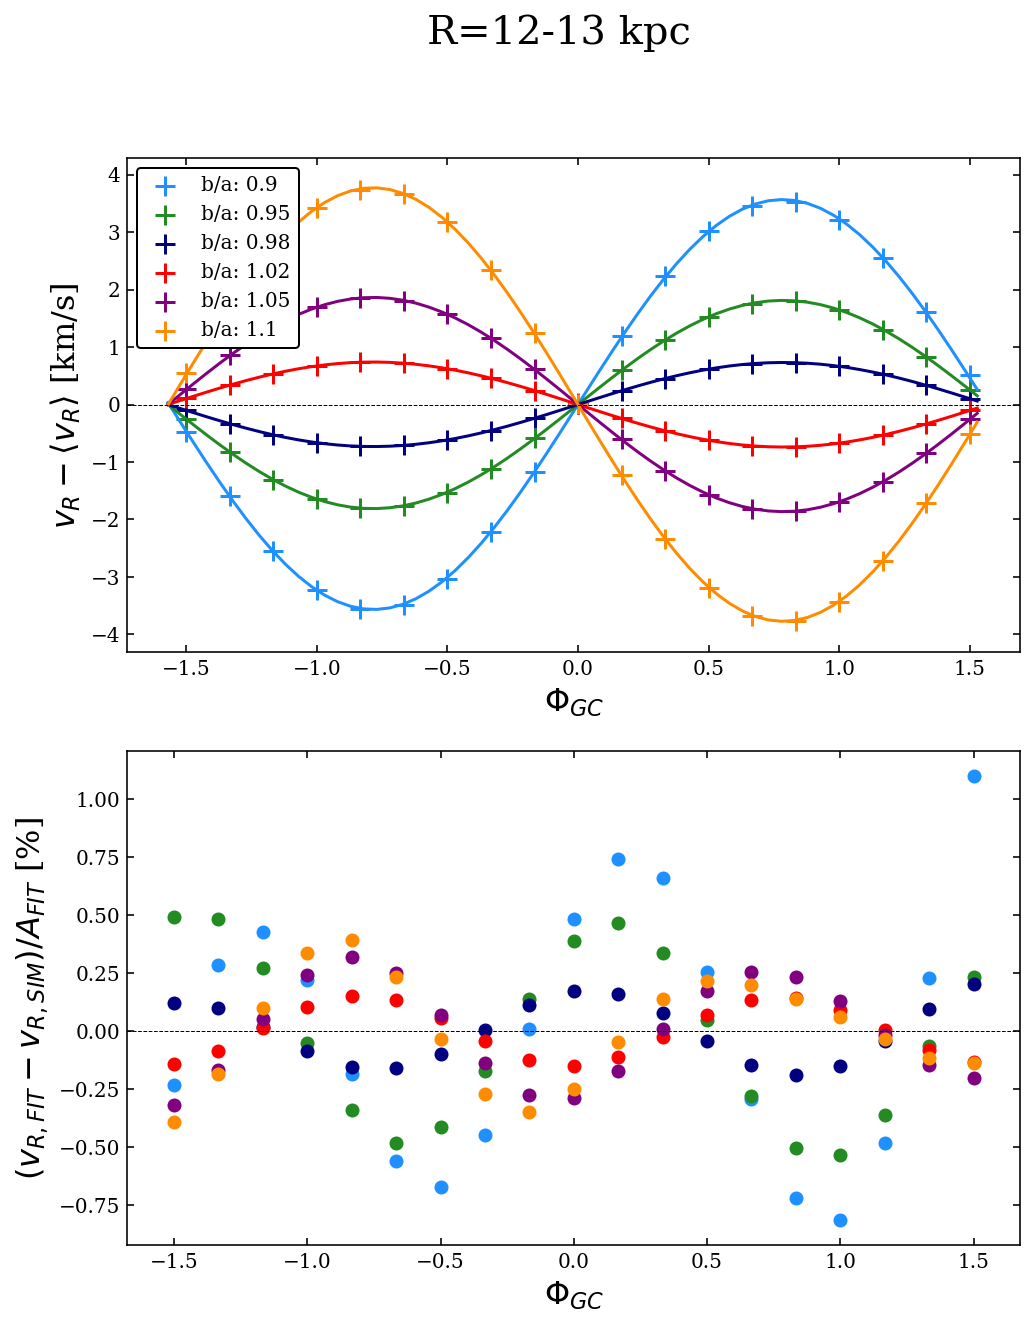

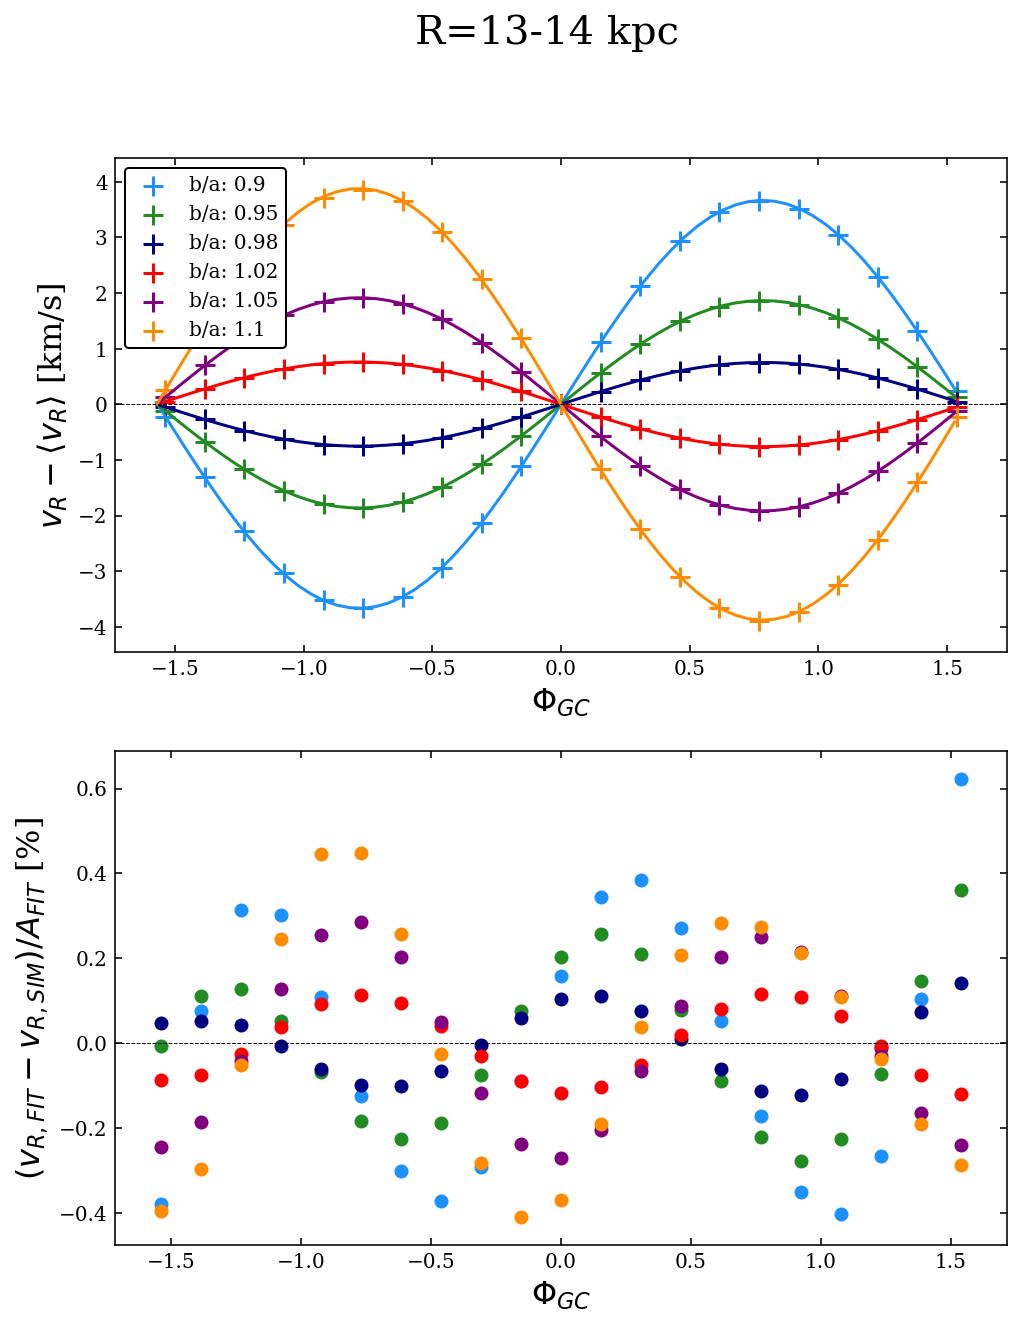

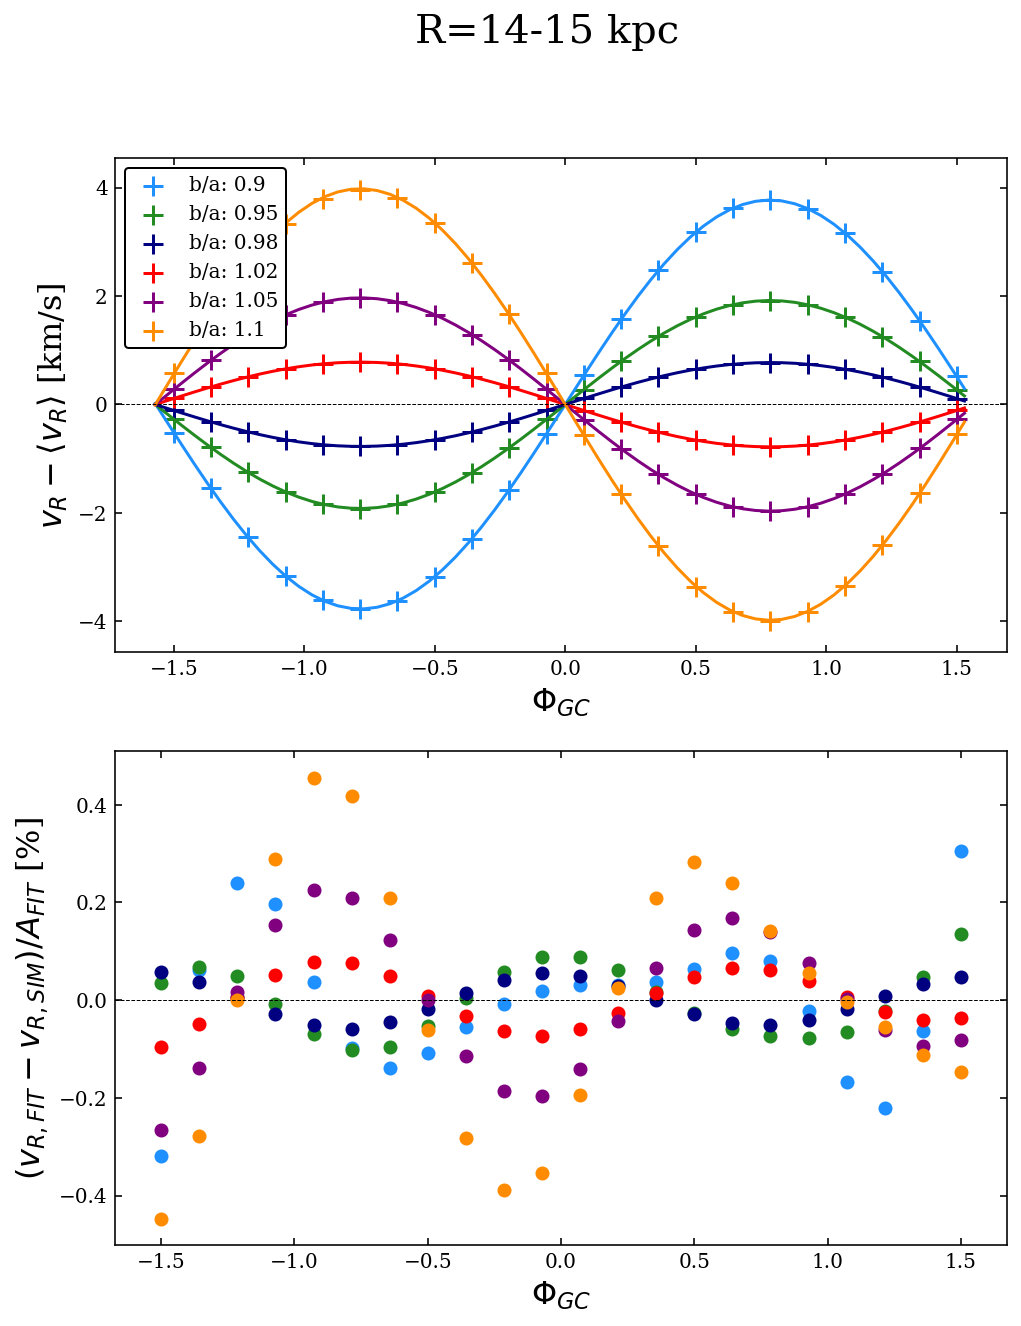

In [24]:
# Create arrays to keep track of array amplitudes
vr_fit_amplitudes = np.zeros((len(R_range),n_files))

# Now loop over each radial bin
for i in range( len(R_range) ):
    
    # Plot
    fig = plt.figure( figsize=(8,10) )
    axs = fig.subplots(nrows=2, ncols=1)
    
    # Loop over each file
    for j in range(n_files):
        
        # Load data
        sim_halo_data = np.load(files[j])
        where_current_r = np.where( sim_halo_data[:,0] == R_range[i] )[0]
        sim_halo_vt = sim_halo_data[ where_current_r, 4 ]
        sim_halo_vt -= np.mean(sim_halo_vt)
        sim_halo_phi = sim_halo_data[ where_current_r, 1 ]
        
        # Plot the data
        axs[0].scatter(sim_halo_phi, sim_halo_vt, color=file_colors[j], marker='+', 
                       label='b/a: '+str(b_values[j]), s=100)
        
        # Plot the cosine fit to the data
        popt, pcov = curve_fit(sinusoid, sim_halo_phi, sim_halo_vt, p0=[10,2.,np.pi/2,0], ftol=0.01)
        fit_phi = np.arange(-np.pi/2,np.pi/2,0.05)
        axs[0].plot( fit_phi, sinusoid(fit_phi, *popt), color=file_colors[j], linestyle='solid')
    
        # Plot the residuals between the fit and the data
        axs[1].scatter( sim_halo_phi, 100*(sinusoid(sim_halo_phi, *popt)-sim_halo_vt)/popt[0], color=file_colors[j] )
        
        # Record the amplitude
        vr_fit_amplitudes[i,j] = popt[0]
        
    ###j
    
    axs[0].legend(loc='upper left')
    axs[0].set_xlabel(r'$\Phi_{GC}$', fontsize=16)
    axs[0].set_ylabel(r'$v_{R}- \langle {v_{R}} \rangle$ [km/s]', fontsize=16)
    axs[0].axhline(0, linestyle='dashed', color='Black', linewidth=0.5)
    
    axs[1].legend(loc='upper left')
    axs[1].set_xlabel(r'$\Phi_{GC}$', fontsize=16)
    axs[1].set_ylabel(r'$(v_{R,FIT}-v_{R,SIM})/A_{FIT}$ [%]', fontsize=16)
    axs[1].axhline(0, linestyle='dashed', color='Black', linewidth=0.5)
    
    fig.suptitle('R='+str(int(R_range[i]))+'-'+str(int(R_range[i]+R_bin_size))+' kpc', fontsize=20)
    
    plt.show()
    plt.close('all')

# Fit the amplitude fluctuations to Kuijken form

Lets assume the velocity fluctuations are equal to the amplitudes of the fitted cosines. Therefore we will fit a function of the form:

$
\Psi(R,\phi) = \Psi_{0}(R) + \psi(R) \cos 2( \phi - \phi_{0} )
$

$
\psi(R) = \psi_{0}(R/R_{0})^{p}
$

So let's see if the amplitude of the velocity fluctuations take the radial form of a power law. Determine $\psi_{0}$, $R_{0}$, and $p$.

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until



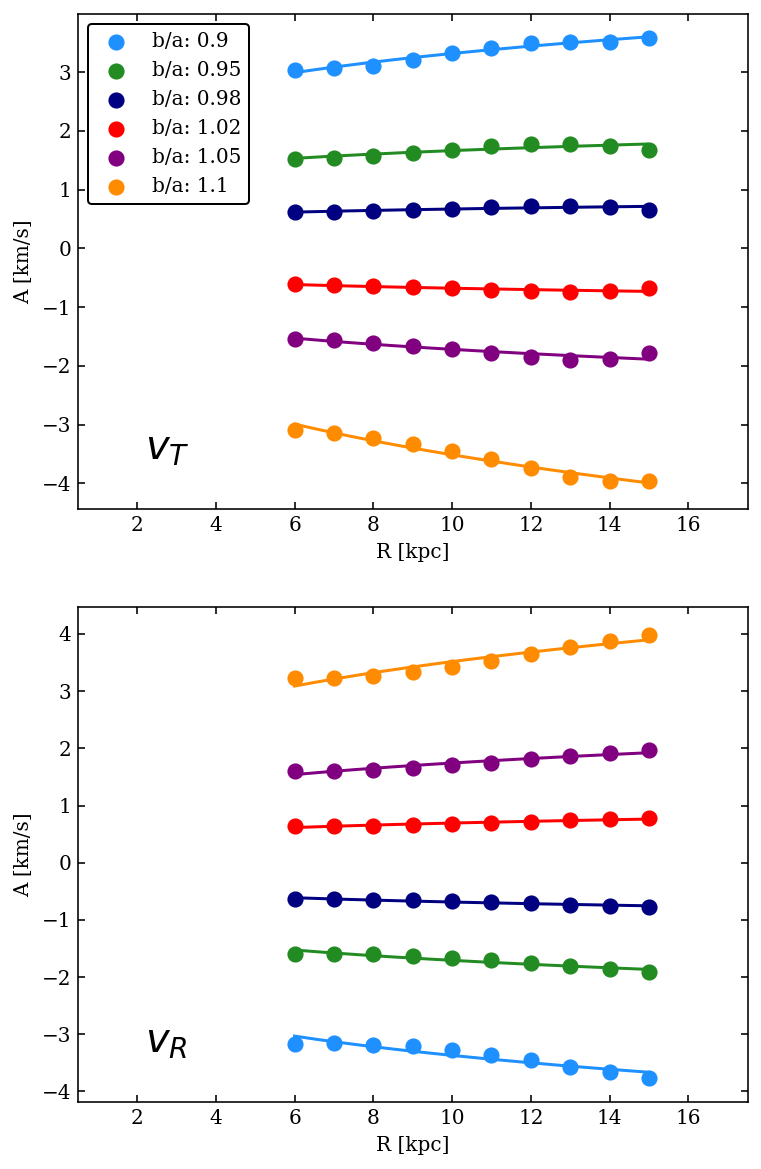

In [40]:
# Define the Kuijken form function
def kuijken_cosine_amplitude(r,psi0,r0,p):
    return psi0*np.power((r/r0),p)
#def

# Loop over each file and plot the amplitude as a function of radius

fig = plt.figure(figsize=(6,10))
axs = fig.subplots(nrows=2, ncols=1)

for i in range(n_files):
    
    ### Tangential velocities
    
    # Fit the Kuijken form to the amplitudes
    popt_vt, pcov_vt = curve_fit(kuijken_cosine_amplitude, R_range+R_bin_size/2, vt_fit_amplitudes[:,i], 
                                 p0=[5,10,0], ftol=0.01)
    fit_R = np.arange(R_range[0]+R_bin_size/2, R_range[-1]+R_bin_size/2, 0.05)
    
    # Plot tangential velocity fluctuations
    axs[0].scatter( R_range+R_bin_size/2 , vt_fit_amplitudes[:,i] , color=file_colors[i], marker='o', 
                       label='b/a: '+str(b_values[i]), s=50 )
    axs[0].plot(fit_R, kuijken_cosine_amplitude(fit_R, *popt_vt), color=file_colors[i])
    
    ### Radial velocities
    
    # Fit the Kuijken form to the amplitudes
    popt_vr, pcov_vr = curve_fit(kuijken_cosine_amplitude, R_range+R_bin_size/2, vr_fit_amplitudes[:,i], 
                                 p0=[5,10,0], ftol=0.01)
    fit_R = np.arange(R_range[0]+R_bin_size/2, R_range[-1]+R_bin_size/2, 0.05)
    
    # Plot radial velocity fluctuations
    axs[1].scatter( R_range+R_bin_size/2 , vr_fit_amplitudes[:,i] , color=file_colors[i], marker='o', 
                       label='b/a: '+str(b_values[i]), s=50 )
    axs[1].plot(fit_R, kuijken_cosine_amplitude(fit_R, *popt_vr), color=file_colors[i])
    
###i

axs[0].set_xlabel('R [kpc]')
axs[0].set_ylabel('A [km/s]')
axs[0].set_xlim( R_range[0]-5, R_range[-1]+3 )
axs[0].annotate(r'$v_{T}$', xy=(0.1,0.1), xycoords='axes fraction', fontsize=20)
axs[0].legend()

axs[1].set_xlabel('R [kpc]')
axs[1].set_ylabel('A [km/s]')
axs[1].set_xlim( R_range[0]-5, R_range[-1]+3 )
axs[1].annotate(r'$v_{R}$', xy=(0.1,0.1), xycoords='axes fraction', fontsize=20)

plt.show()
plt.close('all')